In [6]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("shahrukhkhan/im2latex100k")

print("Path to dataset files:", path)

100%|██████████| 631M/631M [00:05<00:00, 114MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/shahrukhkhan/im2latex100k/versions/7


In [8]:
!ls /root/.cache/kagglehub/datasets/shahrukhkhan/im2latex100k/versions/7

formula_images_processed    im2latex_test.csv	im2latex_validate.csv
im2latex_formulas.norm.csv  im2latex_train.csv


In [2]:
from tokenizer import Tokenizer
from data_layer import make_loader
from encoder import ConvRowEncoder, ConvEncoder
from decoder import LSTMDecoder
from model import Im2Latex
from utils import clean_csvs
import pandas as pd
from IPython.display import display, Math
import matplotlib.pyplot as plt
import torch

In [3]:
path = '/root/.cache/kagglehub/datasets/shahrukhkhan/im2latex100k/versions/7'
path

'/root/.cache/kagglehub/datasets/shahrukhkhan/im2latex100k/versions/7'

In [38]:
!ls /root/.cache/kagglehub/datasets/shahrukhkhan/im2latex100k/versions/7

cleaned_test.csv   formula_images_processed    im2latex_train.csv
cleaned_train.csv  im2latex_formulas.norm.csv  im2latex_validate.csv
cleaned_val.csv    im2latex_test.csv


In [40]:
pd.read_csv(f'{path}/cleaned_train.csv')

,formula,image
0,\alpha _ { 1 } ^ { r } \gamma _ { 1 } + \dots ...,7944775fc9.png
1,\eta = - \frac { 1 } { 2 } \operatorname { l n...,78228211ca.png
2,P _ { ( 2 ) } ^ { - } = \int \beta d \beta d ^...,15b9034ba8.png
3,\Gamma ( z + 1 ) = \int _ { 0 } ^ { \infty } \...,6968dfca15.png
4,\frac { d } { d s } { \bf C } _ { i } = \frac ...,6cead0df53.png
...,...,...
10350,\nu = \frac { - 2 \beta _ { 1 } } { \beta _ { ...,3caf8fcb25.png
10351,"3 \delta _ { l , \, j \pm b _ { r } } = \sum _...",6ed277c793.png
10352,\beta ( \lambda _ { j } ) = ( 2 + \epsilon ) \...,49721f860b.png
10353,E = v \sqrt { Q _ { M } ^ { 2 } + Q _ { E } ^ ...,4cbdf71aaf.png


In [41]:
image_path = f'{path}/formula_images_processed/formula_images_processed'

In [42]:
clean_csvs(
    input_csvs = ['im2latex_test.csv', 'im2latex_train.csv', 'im2latex_validate.csv'],
    images_dir = image_path,
    root_dir = path
)


Cleaning: /root/.cache/kagglehub/datasets/shahrukhkhan/im2latex100k/versions/7/im2latex_test.csv
  → Kept:    10355
  → Removed: 0
  Saved cleaned CSV to: /root/.cache/kagglehub/datasets/shahrukhkhan/im2latex100k/versions/7/cleaned_train.csv

Cleaning: /root/.cache/kagglehub/datasets/shahrukhkhan/im2latex100k/versions/7/im2latex_train.csv
  → Kept:    75275
  → Removed: 0
  Saved cleaned CSV to: /root/.cache/kagglehub/datasets/shahrukhkhan/im2latex100k/versions/7/cleaned_test.csv

Cleaning: /root/.cache/kagglehub/datasets/shahrukhkhan/im2latex100k/versions/7/im2latex_validate.csv
  → Kept:    8370
  → Removed: 0
  Saved cleaned CSV to: /root/.cache/kagglehub/datasets/shahrukhkhan/im2latex100k/versions/7/cleaned_val.csv


In [25]:
!ls /root/.cache/kagglehub/datasets/shahrukhkhan/im2latex100k/versions/7

cleaned_test.csv   formula_images_processed    im2latex_train.csv
cleaned_train.csv  im2latex_formulas.norm.csv  im2latex_validate.csv
cleaned_val.csv    im2latex_test.csv


In [6]:
df = pd.read_csv(f'{path}/im2latex_formulas.norm.csv')
formulas = df['formulas'].tolist()

In [13]:
tokenizer = Tokenizer()
tokenizer.build_vocab(formulas)
print('Vocab size:', tokenizer.vocab_size)

Vocab size: 532


In [14]:
s = formulas[0]
ids = tokenizer.encode(s)
display('Original seq', Math(s))
print('ids:', ids)
display('Decoded seq', Math(tokenizer.decode(ids)))

'Original seq'

<IPython.core.display.Math object>

ids: [1, 70, 6, 5, 12, 100, 4, 7, 5, 118, 4, 24, 40, 159, 59, 5, 29, 4, 7, 5, 12, 40, 146, 4, 70, 6, 5, 12, 100, 4, 7, 5, 118, 4, 24, 40, 7, 5, 48, 4, 59, 5, 29, 4, 7, 5, 12, 40, 7, 5, 48, 4, 146, 4, 40, 40, 7, 5, 48, 4, 5, 16, 5, 40, 7, 5, 48, 4, 12, 40, 4, 5, 40, 15, 40, 7, 5, 48, 4, 4, 4, 113, 35, 25, 64, 7, 5, 48, 48, 4, 8, 40, 9, 12, 5, 16, 5, 35, 4, 5, 44, 4, 4, 36, 25, 64, 8, 40, 9, 119, 13, 19, 23, 2]


'Decoded seq'

<IPython.core.display.Math object>

In [44]:
train_loader = make_loader(
  csv_path = f'./cleaned_train.csv',
  root_dir = image_path,
  tokenizer = tokenizer,
  batch_size = 16,
  shuffle = True,
  img_height = 64,
  num_workers = 2
)

val_loader = make_loader(
  csv_path = f'./cleaned_val.csv',
  root_dir = image_path,
  tokenizer = tokenizer,
  batch_size = 16,
  shuffle = True,
  img_height = 64,
  num_workers = 2
)

In [45]:
batch = next(iter(train_loader))

In [47]:
def visualize_batch(batch, tokenizer, max_items=10):
    images      = batch["images"]
    input_ids   = batch["input_ids"]
    target_ids  = batch["target_ids"]
    formulas    = batch["formulas"]

    B = images.shape[0]
    n = min(B, max_items)

    pad_id = tokenizer.token2id[tokenizer.pad_token]

    def strip_pad(seq):
        if pad_id in seq:
            return seq[:seq.index(pad_id)]
        return seq

    cols = 5
    rows = (n + cols - 1) // cols
    plt.figure(figsize=(cols * 3, rows * 3))

    for i in range(n):
        img = images[i].squeeze(0).cpu().numpy()

        plt.subplot(rows, cols, i+1)
        plt.imshow(img, cmap="gray")
        plt.axis("off")
        plt.title(f"Item {i}")

    plt.suptitle("Batch Images")
    plt.tight_layout()
    plt.show()

    for i in range(n):
        in_ids_list  = strip_pad(input_ids[i].cpu().tolist())
        tgt_ids_list = strip_pad(target_ids[i].cpu().tolist())

        decoded_in   = tokenizer.decode(in_ids_list, remove_special=True)
        decoded_tgt  = tokenizer.decode(tgt_ids_list, remove_special=True)

        print("\n==============================")
        print(f"Item {i}")
        print("Formula:         ", formulas[i])
        print("Input IDs:       ", in_ids_list)
        print("Decoded input:   ", decoded_in)
        print("Target IDs:      ", tgt_ids_list)
        print("Decoded target:  ", decoded_tgt)
    print("==============================\n")


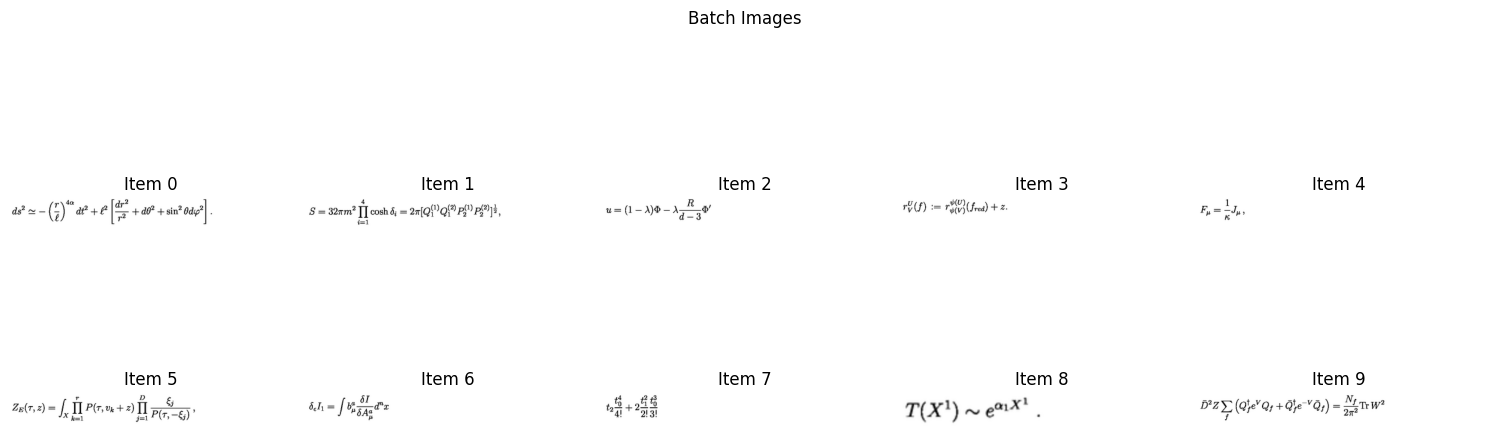


Item 0
Formula:          d s ^ { 2 } \simeq - \left( { \frac { r } { \ell } } \right) ^ { 4 \alpha } d t ^ { 2 } + \ell ^ { 2 } \left[ { \frac { d r ^ { 2 } } { r ^ { 2 } } } + d \theta ^ { 2 } + \operatorname { s i n } ^ { 2 } \theta d \varphi ^ { 2 } \right] .
Input IDs:        [1, 24, 42, 7, 5, 10, 4, 197, 12, 27, 8, 5, 16, 5, 20, 4, 5, 156, 4, 4, 28, 9, 7, 5, 44, 37, 4, 24, 36, 7, 5, 10, 4, 15, 156, 7, 5, 10, 4, 27, 50, 5, 16, 5, 24, 20, 7, 5, 10, 4, 4, 5, 20, 7, 5, 10, 4, 4, 4, 15, 24, 79, 7, 5, 10, 4, 15, 61, 5, 42, 18, 22, 4, 7, 5, 10, 4, 79, 24, 128, 7, 5, 10, 4, 28, 49, 23]
Decoded input:    ds^{2}\simeq-\left({\frac{r}{\ell}}\right)^{4\alpha}dt^{2}+\ell^{2}\left[{\frac{dr^{2}}{r^{2}}}+d\theta^{2}+\operatorname{sin}^{2}\thetad\varphi^{2}\right].
Target IDs:       [24, 42, 7, 5, 10, 4, 197, 12, 27, 8, 5, 16, 5, 20, 4, 5, 156, 4, 4, 28, 9, 7, 5, 44, 37, 4, 24, 36, 7, 5, 10, 4, 15, 156, 7, 5, 10, 4, 27, 50, 5, 16, 5, 24, 20, 7, 5, 10, 4, 4, 5, 20, 7, 5, 10, 4, 4, 4, 15, 24, 79, 

In [48]:
visualize_batch(batch, tokenizer, max_items = 10)

In [49]:
images = batch['images']

In [50]:
def vis_enc(encoder, images = images):
  with torch.no_grad():
    feat = encoder.encoder(images)
    out = encoder(images)
  B, C, Hp, Wp = feat.shape
  print(f'CNN feat: {feat.shape}\nenc_out: {out.shape}')

  plt.figure(figsize = (8, 4))
  plt.imshow(images[0].squeeze(0), cmap = 'gray')
  plt.show()

  plt.figure(figsize = (8, 4))
  plt.imshow(feat[0].mean(dim = 0), cmap = 'viridis')
  plt.colorbar()
  plt.show()

  norms = out[0].norm(dim = 1)
  norms_2d = norms.view(Hp, Wp)

  plt.figure(figsize = (8, 4))
  plt.imshow(norms_2d, cmap = 'viridis')
  plt.colorbar()
  plt.show()

In [25]:
#enc = ConvEncoder(256)
enc = ConvRowEncoder(256)

CNN feat: torch.Size([16, 512, 16, 192])
enc_out: torch.Size([16, 3072, 512])


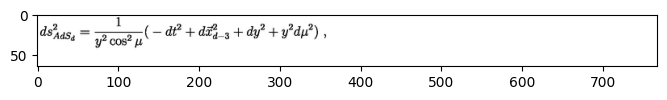

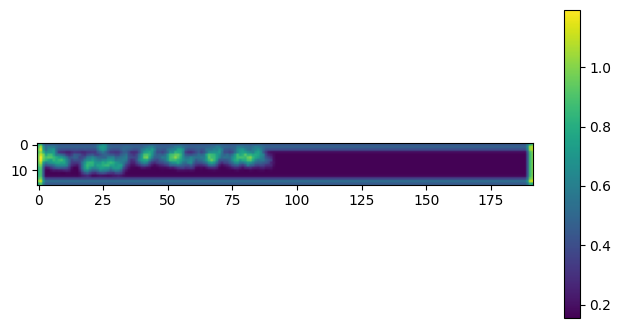

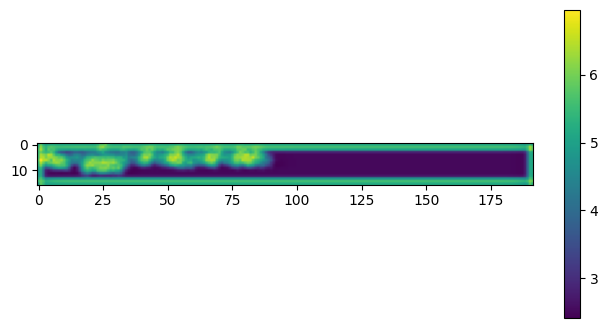

In [26]:
vis_enc(enc, images)

In [70]:
vocab_size = tokenizer.vocab_size
pad_id = tokenizer.token2id[tokenizer.pad_token]
sos_id = tokenizer.token2id[tokenizer.start_token]
eos_id = tokenizer.token2id[tokenizer.end_token]

model = Im2Latex(
  vocab_size,
  encoder_type = 'row',
  attn_size = 128,

)

In [71]:
print(model)

Im2Latex(
  (encoder): ConvRowEncoder(
    (encoder): Sequential(
      (0): Conv2d(1, 64, kernel_size=(1, 1), stride=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (7): ReLU(inplace=True)
      (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (9): ReLU(inplace=True)
      (10): MaxPool2d(kernel_size=(2, 1), stride=(2, 1), padding=0, dilation=1, ceil_mode=False)
      (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (12): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (13): ReLU(inplace=True)
      (14): MaxPool2d(kernel_size=(1, 2

In [56]:
import os
from typing import Optional

import torch
from torch import nn
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import DataLoader


class Trainer:
  """
  Trainer for Im2Latex

  Args:
    model: Im2Latex object
    train_loader: train set
    val_loader: validation set
    pad_id: <pad> id
    device: torch.device
    lr: learning rate
    log_dir: tensorboard logs
    ckpt_dir: checkpoints dir
    ckpt_name: filename for best
    patience: early stopping, epochs wo/ improvement
    resume_from: path from checkpoint to resume, or None
    max_grad_norm: grad clipping norm
    log_interval: how often (in batches) to log within epoch
  """
  def __init__(
      self,
      model,  # Im2Latex
      train_loader: DataLoader,
      val_loader: DataLoader,
      pad_id: int,
      device: torch.device,
      lr: float = 1e-3,
      log_dir: str = './runs',
      ckpt_dir: str = './checkpoints',
      ckpt_name: str = 'best.pt',
      patience: int = 5,
      resume_from: Optional[str] = None,
      max_grad_norm: float = 1.0,
      log_interval: int = 50
  ):
    self.model = model.to(device)
    self.train_loader = train_loader
    self.val_loader = val_loader
    self.pad_id = pad_id
    self.device = device
    self.lr = lr
    self.log_dir = log_dir
    self.ckpt_dir = ckpt_dir
    self.ckpt_name = ckpt_name
    self.patience = patience
    self.resume_from = resume_from
    self.max_grad_norm = max_grad_norm
    self.log_interval = log_interval

    os.makedirs(self.ckpt_dir, exist_ok = True)
    self.ckpt_path = os.path.join(self.ckpt_dir, self.ckpt_name)

    self.writer = SummaryWriter(log_dir = log_dir)

    self.optimizer = torch.optim.Adam(self.model.parameters(), lr = self.lr)
    self.scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
      self.optimizer,
      mode = 'min',
      factor = 0.5,
      patience = 2
    )

    self.ce_loss = nn.CrossEntropyLoss(ignore_index = self.pad_id)

    self.start_epoch = 0
    self.best_val_loss = float('inf')
    self.epochs_no_improve = 0
    self.global_step = 0

    if self.resume_from is not None and os.path.isfile(self.resume_from):
      print(f'[Trainer] Resuming from ckpt: {self.resume_from}')
      self.start_epoch, self.best_val_loss = self._load_checkpoint(
        self.resume_from
      )
    else:
      print('[Trainer] Starting from scratch')

  def _save_checkpoint(self, epoch: int):
    os.makedirs(self.ckpt_dir, exist_ok = True)
    torch.save({
      'epoch': epoch,
      'model_state_dict': self.model.state_dict(),
      'optimizer_state_dict': self.optimizer.state_dict(),
      'best_val_loss': self.best_val_loss
    }, self.ckpt_path)
    print(f'[Trainer] Saved ckpt to {self.ckpt_path}')

  def _load_checkpoint(self, ckpt_path: str):
    ckpt = torch.load(ckpt_path, map_location = self.device)
    self.model.load_state_dict(ckpt['model_state_dict'])
    if 'optimizer_state_dict' in ckpt:
      self.optimizer.load_state_dict(ckpt['optimizer_state_dict'])
    start_epoch = ckpt.get('epoch', 0) + 1
    best_val_loss = ckpt.get('best_val_loss', float('inf'))
    print(
      f'[Trainer] Loaded ckpt from {ckpt_path}, '
      f'epoch = {start_epoch}, best_val_loss = {best_val_loss:.2f}'
    )
    return start_epoch, best_val_loss

  def _train_one_epoch(self, epoch: int) -> float:
    self.model.train()
    running_loss = 0.0
    num_batches = 0
    total_batches = len(self.train_loader)

    for batch_idx, batch in enumerate(self.train_loader, start=1):
      images = batch['images'].to(self.device)       # (B, C, H, W)
      input_ids = batch['input_ids'].to(self.device)
      target_ids = batch['target_ids'].to(self.device)

      self.optimizer.zero_grad()

      logits, _ = self.model(
        images = images,
        tgt_ids = input_ids,
        mem_pad = None,
        need_xattn = False
      )

      B, T, V = logits.shape
      loss = self.ce_loss(
        logits.view(B * T, V),
        target_ids.view(B * T)
      )

      loss.backward()
      if self.max_grad_norm is not None:
        torch.nn.utils.clip_grad_norm_(
          self.model.parameters(), self.max_grad_norm
        )
      self.optimizer.step()

      running_loss += loss.item()
      num_batches += 1

      # per-step TB logging
      self.writer.add_scalar(
        'train/loss_step', loss.item(), self.global_step
      )
      self.global_step += 1

      # ---- logging within epoch ----
      if (
        batch_idx % self.log_interval == 0 or
        batch_idx == 1 or
        batch_idx == total_batches
      ):
        avg_so_far = running_loss / max(1, num_batches)
        print(
          f'  [Train] Epoch {epoch+1} '
          f'Batch {batch_idx}/{total_batches} '
          f'Loss: {loss.item():.4f} '
          f'Avg: {avg_so_far:.4f}'
        )
        # optional: log running avg
        self.writer.add_scalar(
          'train/loss_running_avg',
          avg_so_far,
          self.global_step
        )

    epoch_loss = running_loss / max(1, num_batches)
    self.writer.add_scalar('train/loss_epoch', epoch_loss, epoch)

    return epoch_loss

  @torch.no_grad()
  def _evaluate(self, epoch: int) -> float:
    self.model.eval()
    running_loss = 0.0
    num_batches = 0
    total_batches = len(self.val_loader)

    for batch_idx, batch in enumerate(self.val_loader, start=1):
      images = batch['images'].to(self.device)       # (B, C, H, W)
      input_ids = batch['input_ids'].to(self.device)
      target_ids = batch['target_ids'].to(self.device)

      logits, _ = self.model(
        images = images,
        tgt_ids = input_ids,
        mem_pad = None,
        need_xattn = False
      )

      B, T, V = logits.shape
      loss = self.ce_loss(
        logits.view(B * T, V),
        target_ids.view(B * T)
      )

      running_loss += loss.item()
      num_batches += 1

      # optional: log some progress for val too
      if (
        batch_idx % self.log_interval == 0 or
        batch_idx == total_batches
      ):
        avg_so_far = running_loss / max(1, num_batches)
        print(
          f'  [Val]   Epoch {epoch+1} '
          f'Batch {batch_idx}/{total_batches} '
          f'Loss: {loss.item():.4f} '
          f'Avg: {avg_so_far:.4f}'
        )

    val_loss = running_loss / max(1, num_batches)
    self.writer.add_scalar('val/loss_epoch', val_loss, epoch)
    return val_loss  # <-- important, was missing before

  def train(self, num_epochs: int = 10):
    print('[Trainer] Starting training')
    for epoch in range(self.start_epoch, num_epochs):
      print(f'\nEpoch {epoch + 1}/{num_epochs}')

      train_loss = self._train_one_epoch(epoch)
      print(f'  train_loss: {train_loss:.4f}')

      val_loss = self._evaluate(epoch)
      print(f'  val_loss:   {val_loss:.4f}')

      self.scheduler.step(val_loss)

      if val_loss < self.best_val_loss:
        print(
          f'  ✓ New best val_loss: {val_loss:.4f} '
          f'(prev {self.best_val_loss:.4f})'
        )
        self.best_val_loss = val_loss
        self.epochs_no_improve = 0
        self._save_checkpoint(epoch)
      else:
        self.epochs_no_improve += 1
        print(
          f'  no improvement for '
          f'{self.epochs_no_improve} epoch(s)'
        )
        if self.epochs_no_improve >= self.patience:
          print(
            f'[Trainer] Early stopping triggered '
            f'after {epoch + 1} epochs'
          )
          break

    self.writer.close()
    print('[Trainer] Training finished')
    print(
      f'[Trainer] Best val_loss: {self.best_val_loss:.4f}, '
      f'best checkpoint: {self.ckpt_path}'
    )


In [72]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

trainer = Trainer(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    pad_id=pad_id,
    device=device,
    lr=1e-3,
    log_dir='./runs/exp2',
    ckpt_dir='./checkpoints/exp2',
    ckpt_name='best.pt',
    patience=10,
    log_interval=20,
    #resume_from='./checkpoints/exp1/best.pt'
)


[Trainer] Starting from scratch


In [ ]:
trainer.train(30)

[Trainer] Starting training

Epoch 1/30
  [Train] Epoch 1 Batch 1/3538 Loss: 6.2764 Avg: 6.2764
  [Train] Epoch 1 Batch 20/3538 Loss: 3.6850 Avg: 4.3859
  [Train] Epoch 1 Batch 40/3538 Loss: 3.2793 Avg: 3.8973
  [Train] Epoch 1 Batch 60/3538 Loss: 3.0067 Avg: 3.6512
  [Train] Epoch 1 Batch 80/3538 Loss: 2.9771 Avg: 3.4855
  [Train] Epoch 1 Batch 100/3538 Loss: 2.8693 Avg: 3.3654
  [Train] Epoch 1 Batch 120/3538 Loss: 2.6726 Avg: 3.2787
  [Train] Epoch 1 Batch 140/3538 Loss: 2.6401 Avg: 3.2032
  [Train] Epoch 1 Batch 160/3538 Loss: 2.5945 Avg: 3.1370
  [Train] Epoch 1 Batch 180/3538 Loss: 2.5163 Avg: 3.0793
  [Train] Epoch 1 Batch 200/3538 Loss: 2.5864 Avg: 3.0301
  [Train] Epoch 1 Batch 220/3538 Loss: 2.5037 Avg: 2.9889
  [Train] Epoch 1 Batch 240/3538 Loss: 2.6263 Avg: 2.9503
  [Train] Epoch 1 Batch 260/3538 Loss: 2.5747 Avg: 2.9134
  [Train] Epoch 1 Batch 280/3538 Loss: 2.4178 Avg: 2.8825
  [Train] Epoch 1 Batch 300/3538 Loss: 2.4158 Avg: 2.8536
  [Train] Epoch 1 Batch 320/3538 Loss:

In [59]:
tokenizer.save('vocab.json')

In [60]:
import math
from collections import Counter
from typing import List, Dict, Any

import torch
from torch import nn
from torch.utils.data import DataLoader


# ---------- Helper functions: BLEU + edit distance ----------

def _extract_ngrams(tokens, n: int) -> Counter:
    """
    tokens: list[int] or list[str]
    returns Counter of n-grams (tuples)
    """
    return Counter(
        tuple(tokens[i:i+n]) for i in range(len(tokens) - n + 1)
    )


def compute_corpus_bleu(
    references: List[List[int]],  # one ref per hypothesis
    hypotheses: List[List[int]],
    max_n: int = 4,
    smooth_eps: float = 1e-9,
) -> float:
    """
    Simplified corpus BLEU (single reference per hypothesis).

    Args:
        references: list of reference token id lists
        hypotheses: list of predicted token id lists
        max_n: up to which n-gram to use (4 = BLEU-4)
        smooth_eps: small constant for smoothing

    Returns:
        BLEU score in [0,1]
    """
    assert len(references) == len(hypotheses)
    N = max_n

    matches_by_order = [0] * N
    possible_by_order = [0] * N

    ref_length = 0
    hyp_length = 0

    for ref, hyp in zip(references, hypotheses):
        ref_length += len(ref)
        hyp_length += len(hyp)

        for n in range(1, N + 1):
            ref_ngrams = _extract_ngrams(ref, n)
            hyp_ngrams = _extract_ngrams(hyp, n)

            if len(hyp_ngrams) == 0:
                continue

            overlap = {
                ng: min(count, ref_ngrams.get(ng, 0))
                for ng, count in hyp_ngrams.items()
            }

            matches_by_order[n - 1] += sum(overlap.values())
            possible_by_order[n - 1] += max(len(hyp) - n + 1, 0)

    precisions = []
    for i in range(N):
        if possible_by_order[i] == 0:
            precisions.append(0.0)
        else:
            precisions.append(
                (matches_by_order[i] + smooth_eps)
                / (possible_by_order[i] + smooth_eps)
            )

    if max(precisions) > 0:
        log_prec_sum = sum((1.0 / N) * math.log(p) for p in precisions)
        geo_mean = math.exp(log_prec_sum)
    else:
        geo_mean = 0.0

    if hyp_length == 0:
        return 0.0

    # brevity penalty
    bp = 1.0
    if hyp_length < ref_length:
        bp = math.exp(1.0 - float(ref_length) / float(hyp_length))

    bleu = bp * geo_mean
    return bleu


def levenshtein_distance(ref: List[int], hyp: List[int]) -> int:
    """
    Token-level Levenshtein distance between two lists.
    ref, hyp: list[int] or list[str]
    """
    n = len(ref)
    m = len(hyp)

    if n == 0:
        return m
    if m == 0:
        return n

    dp = [[0] * (m + 1) for _ in range(n + 1)]
    for i in range(n + 1):
        dp[i][0] = i
    for j in range(m + 1):
        dp[0][j] = j

    for i in range(1, n + 1):
        for j in range(1, m + 1):
            cost = 0 if ref[i - 1] == hyp[j - 1] else 1
            dp[i][j] = min(
                dp[i - 1][j] + 1,          # deletion
                dp[i][j - 1] + 1,          # insertion
                dp[i - 1][j - 1] + cost,   # substitution
            )
    return dp[n][m]


# ---------- ModelEvaluator class ----------

class ModelEvaluator:
    """
    Evaluator for Im2Latex model.

    Computes:
      - average CE loss
      - token-level accuracy (ignoring PAD)
      - sequence-level exact match rate
      - corpus BLEU-4 (token-based)
      - average normalized token-level edit distance

    Also prints a few GT vs PRED LaTeX examples.
    """

    def __init__(
        self,
        model: nn.Module,
        tokenizer,
        pad_id: int,
        sos_id: int,
        eos_id: int,
        device: torch.device,
        max_len: int = 150,
        print_samples: int = 5,
    ):
        """
        Args:
            model: trained Im2Latex model (with .greedy_decode)
            tokenizer: your tokenizer with .decode(ids, remove_special=True)
            pad_id: <pad> id
            sos_id: <sos> id
            eos_id: <eos> id
            device: torch.device
            max_len: max decoding length for greedy_decode
            print_samples: number of GT/PRED pairs to print
        """
        self.model = model.to(device)
        self.tokenizer = tokenizer
        self.pad_id = pad_id
        self.sos_id = sos_id
        self.eos_id = eos_id
        self.device = device
        self.max_len = max_len
        self.print_samples = print_samples

        self.ce_loss = nn.CrossEntropyLoss(ignore_index=self.pad_id)

    @torch.no_grad()
    def evaluate(self, data_loader: DataLoader) -> Dict[str, Any]:
        """
        Run evaluation on a DataLoader (e.g. test_loader).

        Returns dict with:
          - "loss"
          - "token_acc"
          - "seq_exact"
          - "bleu4"
          - "avg_norm_edit"
        """
        self.model.eval()

        total_loss = 0.0
        total_batches = 0

        total_tokens = 0
        total_correct_tokens = 0

        total_sequences = 0
        total_exact_match = 0

        printed = 0

        all_refs_tokens: List[List[int]] = []
        all_hyps_tokens: List[List[int]] = []
        norm_edit_sum = 0.0

        for batch in data_loader:
            images = batch["images"].to(self.device)         # (B, C, H, W)
            input_ids = batch["input_ids"].to(self.device)   # (B, T) decoder input
            target_ids = batch["target_ids"].to(self.device) # (B, T) decoder target

            # --- loss & token accuracy ---
            logits, _ = self.model(
                images=images,
                tgt_ids=input_ids,
                mem_pad=None,
                need_xattn=False,
            )  # (B,T,V)

            B, T, V = logits.shape
            loss = self.ce_loss(
                logits.view(B * T, V),
                target_ids.view(B * T),
            )
            total_loss += loss.item()
            total_batches += 1

            pred_tokens = logits.argmax(dim=-1)  # (B,T)
            mask = (target_ids != self.pad_id)   # (B,T)
            correct = (pred_tokens == target_ids) & mask

            total_correct_tokens += correct.sum().item()
            total_tokens += mask.sum().item()

            # --- sequence-level metrics (greedy decode) ---
            pred_ids = self.model.greedy_decode(
                images,
                sos_id=self.sos_id,
                eos_id=self.eos_id,
                max_len=self.max_len,
                mem_pad=None,
            )  # (B, L_pred)

            for b in range(B):
                # reference: strip PAD, cut at EOS
                ref_seq = target_ids[b].tolist()
                ref_seq = [tok for tok in ref_seq if tok != self.pad_id]
                if self.eos_id in ref_seq:
                    ref_seq = ref_seq[: ref_seq.index(self.eos_id) + 1]

                # prediction: cut at EOS
                hyp_seq = pred_ids[b].tolist()
                if self.eos_id in hyp_seq:
                    hyp_seq = hyp_seq[: hyp_seq.index(self.eos_id) + 1]

                all_refs_tokens.append(ref_seq)
                all_hyps_tokens.append(hyp_seq)

                # normalized token-level edit distance
                if len(ref_seq) > 0:
                    dist = levenshtein_distance(ref_seq, hyp_seq)
                    norm_edit_sum += dist / len(ref_seq)
                else:
                    norm_edit_sum += 0.0

                # decode to strings for exact match + printing
                ref_str = self.tokenizer.decode(ref_seq, remove_special=True)
                pred_str = self.tokenizer.decode(hyp_seq, remove_special=True)

                total_sequences += 1
                if pred_str == ref_str:
                    total_exact_match += 1

                if printed < self.print_samples:
                    print("---- Sample", printed + 1, "----")
                    print("GT:   ", ref_str)
                    print("PRED: ", pred_str)
                    print()
                    printed += 1

        avg_loss = total_loss / max(1, total_batches)
        token_acc = total_correct_tokens / max(1, total_tokens)
        seq_exact = total_exact_match / max(1, total_sequences)
        avg_norm_edit = norm_edit_sum / max(1, total_sequences)

        bleu4 = compute_corpus_bleu(
            references=all_refs_tokens,
            hypotheses=all_hyps_tokens,
            max_n=4,
        )

        print("====== Evaluation ======")
        print(f"Avg loss:                  {avg_loss:.4f}")
        print(f"Token accuracy:            {token_acc*100:.2f}%")
        print(f"Seq exact match:           {seq_exact*100:.2f}%")
        print(f"Corpus BLEU-4 (tokens):    {bleu4*100:.2f}%")
        print(f"Avg normalized edit dist:  {avg_norm_edit:.4f}")
        print("=========================")

        return {
            "loss": avg_loss,
            "token_acc": token_acc,
            "seq_exact": seq_exact,
            "bleu4": bleu4,
            "avg_norm_edit": avg_norm_edit,
        }


In [62]:
model = trainer.model

In [63]:
model

Im2Latex(
  (encoder): ConvEncoder1D(
    (cnn): Sequential(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (6): ReLU(inplace=True)
      (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (10): ReLU(inplace=True)
      (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
 

In [66]:
evaluator = ModelEvaluator(
    model=model,
    tokenizer=tokenizer,
    pad_id=tokenizer.token2id[tokenizer.pad_token],
    sos_id=tokenizer.token2id[tokenizer.start_token],
    eos_id=tokenizer.token2id[tokenizer.end_token],
    device=trainer.device,
    max_len=150,
    print_samples=5,
)

test_loader = make_loader(
  csv_path = f'./cleaned_test.csv',
  root_dir = image_path,
  tokenizer = tokenizer,
  batch_size = 16,
  shuffle = False,
  img_height = 64,
  num_workers = 2
)

In [67]:
metrics = evaluator.evaluate(test_loader)

---- Sample 1 ----
GT:    P_{(2)}^{-}=\int\betad\betad^{9}pd^{8}\lambda\Phi(-p,-\lambda)\left(-\frac{p^{I}p^{I}}{2\beta}\right)\Phi(p,\lambda)\,.
PRED:  P_{(2)}^{2}=\int\betad\betad^{3}\lambda\Phi(-p,,-\lambda)\left(-\frac{p^{2}\beta^{T}}{2\beta}\right)\Phi(p,\lambda)\,.

---- Sample 2 ----
GT:    \Gamma(z+1)=\int_{0}^{\infty}\,\,dx\,\,e^{-x}x^{z}.
PRED:  \Gamma(z+1)=\int_{0}^{\infty}dx\;e^{-x}x^{z}.

---- Sample 3 ----
GT:    Z=\sum_{spins}\prod_{cubes}W(a|e,f,g|b,c,d|h),
PRED:  Z=\sum_{s\vec{p}ins}\operatorname{ches}W(a|e,f,g|b,c,d|h\rangle,_{n},(m_{-},m_{(n)},m_{(n)},m_{(n)},m_{(n)},m_{(n)},m_{(n)},m_{(n)},m_{(n)},m_{(n)},m_{(n)},m_{(n)},m_{(n)},m_

---- Sample 4 ----
GT:    \left\{Q^{i},Q^{j}\right\}=c^{ij}\Gamma^{M}CP_{M}+Cc^{ij}Z,
PRED:  \left\{Q^{i},Q^{j}\right\}=c^{ij}\Gamma^{M}CP_{M}+C_{c}i^{ij}Z_{,h}+CP_{,h}(m_{,-},(m)_{(m,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-

---- Sample 5 ----
GT:    \breve{c}_{n,\nu}=\sum_{m=n}^{2n}{\frac{\Gamma\left(